### Imports

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

### Data

In [39]:
mangaHIall = Table.read('input/mangaHIall_classified.txt', format = 'ascii.commented_header')
mangaHIall_walls = Table.read('input/mangaHIall_walls.txt', format = 'ascii.commented_header')
mangaHIall_voids = Table.read('input/mangaHIall_voids.txt', format = 'ascii.commented_header')

mangaHI = Table.read("out_txt/GBT_HI_with_MStar.txt", format="ascii.commented_header")
alfaHI = Table.read("out_txt/ALFALFA_HI_with_MStar.txt", format="ascii.commented_header")

### HI correction

In [40]:
def HI_correction(data):
    c = 1/(data['NSA_ba'])**0.12
    data['HI_corrected'] = np.ones(len(data), dtype = np.float64)
    data['HI_corrected'] = c * data['HI']


In [41]:
HI_correction(mangaHIall)
HI_correction(mangaHIall_walls)
HI_correction(mangaHIall_voids)

### Adding SNR data to mangaHIall, mangaHIall_walls, and mangaHIall_voids tables from mangaHI and alfaHI tables

In [42]:
def add_SNR_col(data):
    
    data['SNR'] = np.NaN * np.ones(len(data), dtype = np.float64)

    for i in range(len(mangaHI)):
        for j in range(len(data)):
            if (data['MaNGA_plate'][j], data['MaNGA_IFU'][j]) == (mangaHI['Plate'][i], mangaHI['IFU'][i]):
                data['SNR'][j] = mangaHI['snr'][i]
        
        

 
    for i in range(len(alfaHI)):
        for j in range(len(data)):
            if (data['MaNGA_plate'][j], data['MaNGA_IFU'][j]) == (alfaHI['Plate'][i], alfaHI['IFU'][i]):
                data['SNR'][j] = alfaHI['SNR'][i]
    
#     plate_boolean = mangaHIall['MaNGA_plate'] == mangaHI['Plate']
#     ifu_boolean = mangaHIall['MaNGA_IFU'] == mangaHI['IFU']
#     match_boolean = np.logical_and(plate_boolean, ifu_boolean)    
    
#     plate_boolean = mangaHIall['MaNGA_plate'] == alfaHI['Plate']
#     ifu_boolean = mangaHIall['MaNGA_IFU'] == alfaHI['IFU']
#     match_boolean = np.logical_and(plate_boolean, ifu_boolean) 
#     mangaHIall['SNR'][match_boolean] = alfaHI['SNR'][i]

In [43]:
add_SNR_col(mangaHIall)
add_SNR_col(mangaHIall_walls)
add_SNR_col(mangaHIall_voids)

### Adding Inclination Angle to mangaHIall

In [44]:
def add_Inclination_Angle_col(data):
    data['Inc_Angle'] = np.ones(len(data), dtype = np.float64)

    q=0.2 #intrinsic disc thickness

    for i in range(len(data)):
        if data['NSA_ba'][i] >= 0.200:
            data['Inc_Angle'][i] = (np.arccos(np.sqrt((data['NSA_ba'][i]**2 - q**2)/(1-q**2))))
        else:
            data['Inc_Angle'][i] = (np.arccos(np.sqrt((data['NSA_ba'][i]**2))))  
            

In [45]:
add_Inclination_Angle_col(mangaHIall)
add_Inclination_Angle_col(mangaHIall_walls)
add_Inclination_Angle_col(mangaHIall_voids)

### Velocity correction

In [46]:
def vel_correction(data):
    
    data['WF50_corrected'] = np.ones(len(data), dtype = np.float64)
    data['WP20_corrected'] = np.ones(len(data), dtype = np.float64)
    data['logSNR'] = np.ones(len(data), dtype = np.float64)
    data['logSNR'] = np.log10(data['SNR'])

    v = 5.00 #km/s
    t = 6.5 #km/s,
    l = 0

    for i in range(len(data)):
        if data['Inc_Angle'][i] == 0 or data['Inc_Angle'][i] == np.pi:
            data['Inc_Angle'][i] = np.pi/2
        else:
            if 0<data['logSNR'][i]<0.6:
                l = 0.05
            elif 0.6<data['logSNR'][i]<1.1:
                l = -0.4685 + 0.785*data['logSNR'][i]
            elif data['logSNR'][i]>1.1:
                l = 0.395          
        WF50_corr = (((data['WF50'][i] - (2*v*l))/(1+data['NSA_redshift'][i])) - t) * (1/np.sin(data['Inc_Angle'][i]))
        WP20_corr = (((data['WP20'][i] - (2*v*l))/(1+data['NSA_redshift'][i])) - t) * (1/np.sin(data['Inc_Angle'][i]))
        data['WF50_corrected'][i] = WF50_corr
        data['WP20_corrected'][i] = WP20_corr
        
    

In [47]:
vel_correction(mangaHIall)
vel_correction(mangaHIall_walls)
vel_correction(mangaHIall_voids)

### Writing corrected files

In [48]:
mangaHIall.write('input/mangaHIall_classified_corrected.txt', format = 'ascii.commented_header', overwrite = True)
mangaHIall_walls.write('input/mangaHIall_walls_corrected.txt', format = 'ascii.commented_header', overwrite = True)
mangaHIall_voids.write('input/mangaHIall_voids_corrected.txt', format = 'ascii.commented_header', overwrite = True)

### WF50_corrected and M* relationship

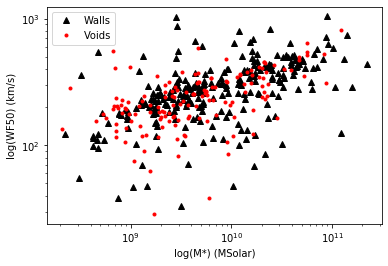

In [49]:
#Plot log(corrected WF50) vs log(MStar) while having the voids and walls separated

plt.loglog(mangaHIall['NSA_Mstar-walls'], mangaHIall['WF50_corrected'], '^', label = 'Walls', color = 'black')
plt.loglog(mangaHIall['NSA_Mstar-voids'], mangaHIall['WF50_corrected'], '.', label = 'Voids', color = 'red')
plt.ylabel('log(WF50) (km/s)')
plt.xlabel('log(M*) (MSolar)')
plt.legend()
plt.savefig('plots/logWF50_corrected-logMstar_VoidsAndWalls.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.show()